In [12]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from functions import *
import arviz as az
import json

In [13]:
file = open("full_mcmc.pkl", "rb")
trace_full = pickle.load(file)

In [14]:
m = 10
n_mcmc, p = np.shape(trace_full['alpha'])
q = np.shape(trace_full['b'])[1]

In [15]:
p, q

(5, 5)

In [5]:
samples = np.zeros((m,n_mcmc,p+q+1))
mle = np.zeros((m,p+q+1))
for i in range(m) :
    file = open("mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace_dc = pickle.load(file)
    samples[i,:,0:p] = trace_dc['alpha']
    samples[i,:,p:(p+q)] = trace_dc['b']
    samples[i,:,(p+q):(p+q+1)] = np.reshape(trace_dc['c'], [n_mcmc,1])
    
    file = open("mle_chunk"+str(i+1)+".pkl", "rb")
    mle_dc = pickle.load(file)
    mle[i,0:p] = mle_dc['alpha']
    mle[i,p:(p+q)] = mle_dc['b']
    mle[i,(p+q):(p+q+1)] = mle_dc['c']

In [6]:
samples_combined = double_parallel_MC(samples, mle)
dpMC_CI = np.percentile(np.reshape(samples_combined, [np.prod(np.shape(samples_combined)[0:2]),np.shape(samples_combined)[-1]]), 
                        q=[2.5,97.5], axis=0)
alpha_ci_dpMC = dpMC_CI[:,0:p]
b_ci_dpMC = dpMC_CI[:,p:(p+q)]
c_ci_dpMC = dpMC_CI[:,(p+q):(p+q+1)]

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 22358.41it/s]


In [7]:
file = open("full_mcmc.pkl", "rb")
trace = pickle.load(file)
c_ci_full = np.percentile(trace['c'],axis=0,q=[2.5,97.5])
alpha_ci_full = np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])
b_ci_full = np.percentile(trace['b'],axis=0,q=[2.5,97.5])

c_ci_dc = np.zeros(2)
alpha_ci_dc = np.zeros((2,p))
b_ci_dc = np.zeros((2,q))
for i in range(m) :
    file = open("mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    c_ci_dc += np.percentile(trace['c'],axis=0,q=[2.5,97.5])/m
    alpha_ci_dc += np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])/m
    b_ci_dc += np.percentile(trace['b'],axis=0,q=[2.5,97.5])/m

In [8]:
## temp
def cred_ints_laplace(quantiles):
    n_q = len(quantiles)
    with open("laplace.json") as f:
        laplace = json.load(f)
    modes, hessian = np.array(laplace['mode']), np.array(laplace['hessian'])
    var_names = laplace['var_names']
    stds = np.sqrt(np.diag(np.linalg.inv(-hessian)))
    res = np.zeros((p+q+1, n_q))
    i = 0
    for mode, std in zip(modes, stds):
        res[i,:] = norm.ppf(np.array(quantiles) / 100, loc=mode, scale=std)
        i += 1
    res = res.T
    return (res[:,:p], res[:,p], res[:,(p+1):])

In [9]:
def cred_ints_vb(quantiles):
    n_q = len(quantiles)
    with open("vb.json") as f:
        vb = json.load(f)
    res = {}
    res['alpha'] = np.percentile(np.array(vb['alpha']), axis=0, q=quantiles)
    res['c'] = np.percentile(np.array(vb['c']), axis=0, q=quantiles)
    res['b'] = np.percentile(np.array(vb['b']), axis=0, q=quantiles)
    return res['alpha'], res['c'], res['b']

In [10]:
# laplace's approximation
alpha_ci_lap, c_ci_lap, b_ci_lap = cred_ints_laplace([2.5, 97.5])
alpha_ci_vb, c_ci_vb, b_ci_vb = cred_ints_vb([2.5, 97.5])

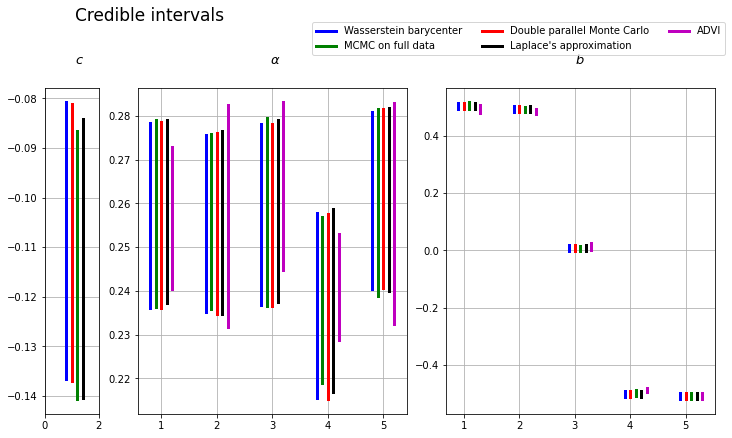

In [16]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True

f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, p, q]}, figsize=(12,6))

# a0.plot(1, c, "ro")
a0.plot([0.8,0.8], c_ci_dc, "b-")
a0.plot([1.2,1.2], c_ci_full, "g-")
a0.plot([1,1], c_ci_dpMC, "r-")
a0.plot([1.4,1.4], c_ci_lap, 'k-')
a0.axis(xmin=0,xmax=2)

# a1.plot(np.arange(1,p+1), alph, "ro")
for i in range(p) :
    a1.plot([i+0.8,i+0.8], alpha_ci_dc[:,i], "b-")
    a1.plot([i+0.9,i+0.9], alpha_ci_full[:,i], "g-")
    a1.plot([i+1,i+1], alpha_ci_dpMC[:,i], "r-")
    a1.plot([i+1.1, i+1.1], alpha_ci_lap[:,i], "k-")
    a1.plot([i+1.2, i+1.2], alpha_ci_vb[:,i], "m-")
    

# a2.plot(np.arange(1,q+1), b, "ro")
for i in range(q) :
    if i < (q-1) :
        a2.plot([i+0.9,i+0.9], b_ci_dc[:,i], "b-")
        a2.plot([i+1.1,i+1.1], b_ci_full[:,i], "g-")
        a2.plot([i+1,i+1], b_ci_dpMC[:,i], "r-")
        a2.plot([i+1.2,i+1.2], b_ci_lap[:,i], "k-")
        a2.plot([i+1.3, i+1.3], b_ci_vb[:,i], "m-")
    if i == (q-1) :
        a2.plot([i+0.9,i+0.9], b_ci_dc[:,i], "b-", label="Wasserstein barycenter")
        a2.plot([i+1.1,i+1.1], b_ci_full[:,i], "g-", label="MCMC on full data")
        a2.plot([i+1,i+1], b_ci_full[:,i], "r-", label="Double parallel Monte Carlo")
        a2.plot([i+1.2,i+1.2], b_ci_lap[:,i], "k-", label="Laplace's approximation")
        a2.plot([i+1.3,i+1.3], b_ci_lap[:,i], "m-", label="ADVI")

cap_height = 0.65
plt.text(x=-6.0, y=cap_height, s=r"$c$", fontsize=13)
plt.text(x=-2.5, y=cap_height, s=r"$\alpha$", fontsize=13)
plt.text(x=3.0, y=cap_height, s=r"$b$", fontsize=13)
plt.text(x=-6, y=cap_height+0.15, s=r"Credible intervals", fontsize=17)
plt.legend(ncol=3, loc=(-0.5,1.1))
f.savefig('binary_AR_CI.pdf', bbox_inches='tight', dpi=500)

In [16]:
eff_samp_sizes = np.zeros((10, p+q+1))
for i in range(m) :
    file = open("mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    eff_samp_sizes[i,:p] = [az.ess(col) for col in trace['alpha'].T]
    eff_samp_sizes[i,p:(p+q)] = [az.ess(col) for col in trace['b'].T]
    eff_samp_sizes[i,p+q] = az.ess(trace['c'])

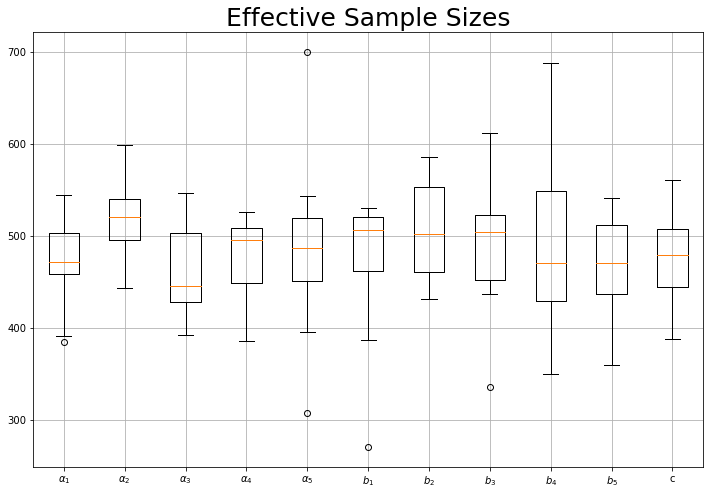

In [17]:
xlabs = [r"$\alpha_" + str(i+1) + "$"  for i in range(p)] + [r'$b_' + str(i+1) + '$' for i in range(q)] + ['c']
fig = plt.figure(figsize=(12,8))
plt.boxplot(eff_samp_sizes)
plt.xticks(np.arange(1, 12), labels=xlabs)
plt.title("Effective Sample Sizes", fontsize=25)
fig.savefig('binary_ar_ess.pdf', bbox_inches='tight', dpi=2000)
plt.show()

['alpha_1',
 'alpha_2',
 'alpha_3',
 'alpha_4',
 'alpha_5',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'c']